# Initialization

In [440]:
%reset -f
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
import progressbar
import pickle

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


# Read original data file

Text(0.5, 0, '20011014.csv')

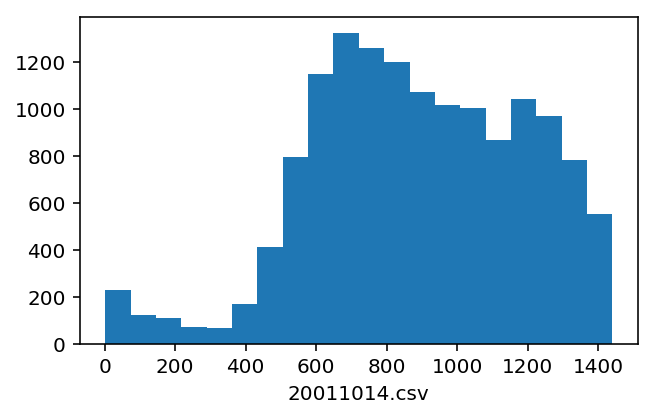

In [441]:
path = '/Users/shuffle/Desktop/GAN/Code/data/'
file = '20011014.csv'

data_2 = pd.read_csv(path+file)
data_2['start_datetime'] = pd.to_datetime(data_2['start_datetime'])
data_2.sort_values('start_datetime',inplace=True)
start_datetime = data_2.start_datetime.values
# 单位是分钟，minute of day
start_datetime = ((start_datetime - np.datetime64('2001-10-14')).astype(float)/1e9/60).astype(float)
n_arrival = len(data_2)
plt.figure(figsize=(5,3))
none = plt.hist(start_datetime,bins=20)
plt.xlabel(file)

In [442]:
# Read your data here.

# count_tw_min: the length of subinterval. 
count_tw_min = 5 #Read your data here#


# Units of arrival time should be converted to miniute, if not. Range of arrival time should be 0~1440, since there's 1440 minutes totally in one day.

# counts: number of arrivals in each subinterval.
subinterval = np.arange(0,24*60+1,count_tw_min)
counts = np.histogram(start_datetime,bins=subinterval)[0] #Read your data here#


Text(0, 0.5, 'Number of arrivals in each subinterval')

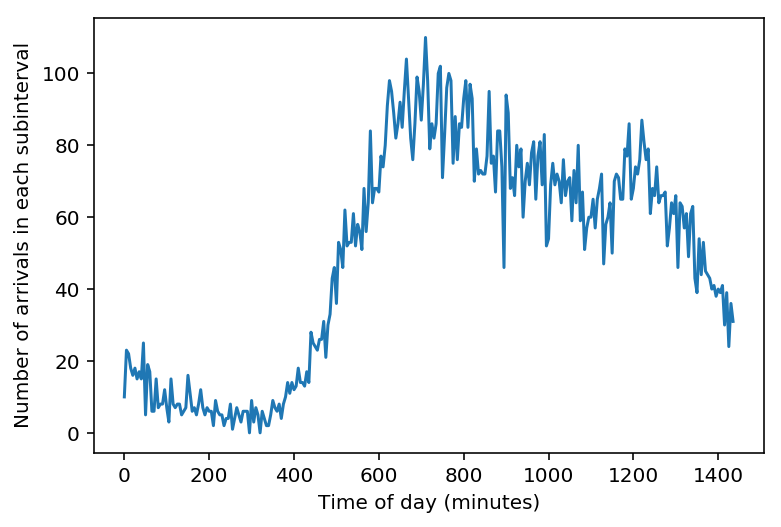

In [443]:
# Get a overview of arrival data.
subinterval = np.arange(0,24*60+1,count_tw_min)
plt.plot(subinterval[:-1],counts)
plt.xlabel('Time of day (minutes)')
plt.ylabel('Number of arrivals in each subinterval')

# Get density function by Maximum Likelihood Estimation (MLE)

According to the assumption, whether we are using piecewise linear density (PL) to model the arrival data, we need to specify the time nodes to divide the whole day into several time intervals. And inside each time interval, density function shares the same expression (has same slope and intercept for PL).

For example, if we set time nodes as 0 min, 180 min, 540 min and 1440 min, which means we divide the whole day into these period: \[0,180\], \[180, 540\], \[540, 1440\]. Then for PL density function, we need a total of four parameters to fit the arrival process, i.e., the density at time 0 min, 180 min, 540 min and 1440 min.


In [444]:
# Specify the time nodes. These time nodes are where the slope of piecewise density function changes.

# If time intervals are divided equally, you can use the following code.

# period_length: length of each interval in minutes.
'''
period_length = 120
interval = np.arange(0,1440+1,period_length) 
'''

# Or you can also set time nodes manually. Do set 0 as the first element of the list, and 1440 as the last element of the list.
# INTERVAL should be subset of SUBINTERVAL.

interval = np.array([0, 180, 540, 1440])

In [445]:
# n_para: number of parameters to be determined
n_para = len(interval)


# lam: decision variables, i.e., density at the time nodes we set.
lam = cp.Variable(n_para)

# integral: integral of density function over the whole day.
integral = 0
for i in range(n_para - 1):
    int_start = interval[i]
    int_end = interval[i+1]
    len_int = int_end - int_start
    integral += (lam[i]+lam[i+1])*len_int/2
    

n_arrival = np.sum(counts)

In [446]:
# obj_func_log: DataFrame to store all the information for each subinterval count.
# count_number: number of arrivals in each subinterval.
# interval_index: denotes the interval index that the subinterval belongs to. Interval index start from 0, and grows by 1.
# log_lam: the log of density function item in the objective function.
obj_func_log = pd.DataFrame(columns=['count_number', 'subinterval_start', 'subinterval_end', 'interval_index','log_lam'])
obj_func_log['count_number'] = counts
obj_func_log['subinterval_start'] = subinterval[:-1]
obj_func_log['subinterval_end'] = subinterval[1:]

for i in range(n_para - 1):
    print('now we run to '+str(i)+'-th interval')
    int_start = interval[i]
    int_end = interval[i+1]
    
    
    obj_func_log.loc[(obj_func_log['subinterval_start'] >= int_start)&(obj_func_log['subinterval_end'] <= int_end),'interval_index'] = i
    lam_start = lam[i]
    lam_end = lam[i+1]
    
    int_slope = (lam_end-lam_start)/(int_end-int_start)
    
    obj_func_log.loc[obj_func_log['interval_index']==i,'log_lam'] = obj_func_log.loc[obj_func_log['interval_index']==i].apply(lambda x: cp.log(((x.subinterval_end+x.subinterval_start)/2-int_start)*int_slope+lam_start),axis=1)

    

obj_func_log['log_lam_to_sum'] = obj_func_log['log_lam'] * obj_func_log['count_number']


# Construct the optimization problem.
sum_log = cp.sum(cp.hstack(obj_func_log['log_lam_to_sum'].values))
objective = cp.Maximize(- integral + sum_log)
constraints = [lam >= 0]
prob = cp.Problem(objective, constraints)

# Solve the problem
result = prob.solve(solver=cp.MOSEK)


now we run to 0-th interval
now we run to 1-th interval
now we run to 2-th interval


# Result visulization

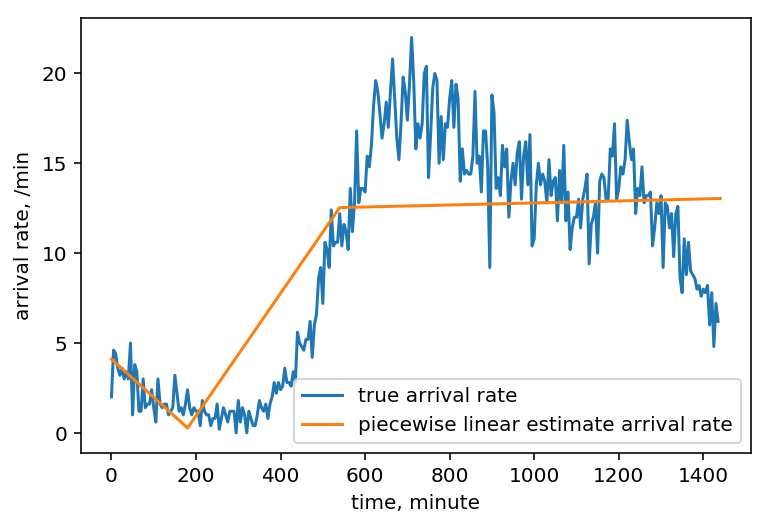

In [447]:
# Plot results

plt.plot(subinterval[:-1],counts/count_tw_min)
plt.plot(interval,lam.value)

plt.xlabel('time, minute')
plt.ylabel('arrival rate, /min')
plt.legend(['true arrival rate','piecewise linear estimate arrival rate','piecewise constant estimate arrival rate'])

# Generate fake arrival data according to estimated density

## piecewise density

### Inversion

In [448]:
# 时间单位 统一为 小时
import math
vexp = np.vectorize(math.exp)

In [449]:
interval_hour = interval/60
lam_hour = lam.value * 60
n_interval = len(interval_hour) - 1

In [450]:
# print('Generate fake arrival data according to estimated piecewise linear density with inversion method')
def GenerateFromPL_inversion(n_exper,interval_hour,lam):
    '''
    GenerateFromPW is used to generate realization of Poisson Process given piecewise linear density function.
    Input:
        n_exper: number of fake data series generated
        interval_hour: the time nodes in hours
        lam：density at each time node, unit is number of arrivals per hour
    Output:
        T_list_mat: a matrix with n_exper rows. Each row is a realization of the Poisson Process. 
        However, since each realization of the same poisson process may contains different amount of arrivals, so we set the number of columns of the matrix
        big enough to be able to storage almost all the possible realization. The unoccupied part of the matrix is set to -1, so that we can recover the realization
        from the matrix easily.
        
        For example, if we set n_exper to 2. And two realization is [1, 1.3, 5.2, 9.8] and [1.1, 2.4, 7.2, 6.8, 7.6, 9.1, 9.9]. Then the matrix may be:
            [[1,    1.3,  5.2,  9.8,  -1,   -1,   -1,  -1,  -1],
             [1.1,  2.4,  7.2,  6.8,  7.6,  9.1,  9.9, -1,  -1]].
        To recover the first realization, we use code: 
            first_realization = T_list_mat[0,:];
            first_realization = first_realization[first_realization > 0];
    '''


    t_k = interval_hour
    # l_k: length of each interval
    l_k = interval_hour[1:] - interval_hour[:-1]
    # a_k: slope of density function on each interval
    a_k = (lam[1:] - lam[:-1])/l_k
    # b_k: intercept of density function on each interval
    b_k = lam[:-1] - a_k * interval_hour[:-1]

    t_max = max(interval_hour)

    u_j = np.zeros(n_interval)
    for j in range(n_interval):
        u_j[j] = 1 - math.exp(-(a_k[j]/2)*(t_k[j+1]**2-t_k[j]**2) - b_k[j]*(t_k[j+1]-t_k[j]))


    # Calculate the expectation of arrivals, and allocate memory ahead.
    E_n_arrival = 0
    for i in range(n_interval):
        interval_start = t_k[i]
        interval_end = t_k[i+1]
        lam_start = lam[i]
        lam_end = lam[i+1]
        E_n_arrival += (lam_start+lam_end)*(interval_end-interval_start)/2
        
    
    # T_list_mat: a matrix of size (number of experiment) * (2 * expectation of arrivals)
    # Each row of T_list_mat represents a realization of arrival process
    # Typically the probability that the number of arrivals generated is greater than two times of the expectation of arrivals is negligible,
    # So set the number of columns of T_list_mat as 2 * expectation of arrivals is sufficiently large.
    T_list_mat = np.ones((n_exper, 2*int(E_n_arrival)))*-1

    # np.random.seed(0)
    print_T_i = False
    print_k = False

    with progressbar.ProgressBar(max_value=n_exper) as bar:

        for i in range(n_exper):

            bar.update(i)

            t_i_1 = 0
            last_arrival = t_i_1
            k = 0

            T_list_mat[i,0] = t_i_1
            not_break = True

            arrival_id = 1

            while (t_i_1 < t_max) & not_break:
                u = np.random.rand()

                try:
                    u_k = 1 - math.exp(-(a_k[k]/2) * (t_k[k+1]**2-t_i_1**2)-b_k[k] * (t_k[k+1]-t_i_1))
                except:
                    u_k = 1
                while u > u_k:
                    u = (u-u_k)/(1-u_k)
                    t_i_1 = t_k[k+1]
                    k += 1
                    if print_k:
                        print(k)
                    if k == n_interval:
                        not_break = False
                        break
                    u_k = u_j[k]
                else:
                    if a_k[k] != 0:
                        T_i = (-b_k[k]+\
                                math.sqrt(b_k[k]**2 + a_k[k]**2*t_i_1**2 + 2*a_k[k]*b_k[k]*t_i_1 - 2*a_k[k]*math.log(1-u)))/a_k[k]
                    else:
                        T_i = t_i_1 - math.log(1-u)/b_k[k]     
                interarrival = T_i - last_arrival
                t_i_1 = T_i
                last_arrival = t_i_1
                if not_break & print_T_i:
                    print('T_i =',T_i) 
                T_list_mat[i,arrival_id] = T_i
                arrival_id += 1      
    return T_list_mat

In [451]:
n_exper = 100
T_list_mat_pl_inversion = GenerateFromPL_inversion(n_exper,interval_hour,lam_hour)

100% (100 of 100) |######################| Elapsed Time: 0:00:18 Time:  0:00:18


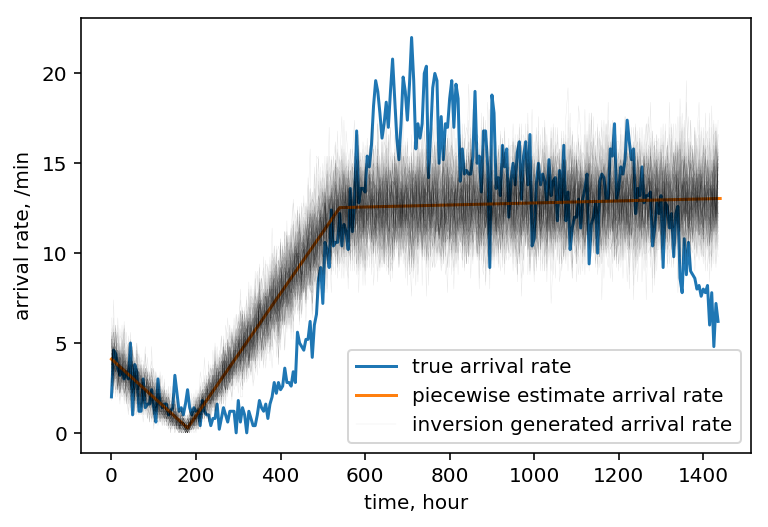

In [452]:
# Plot true arrival rate.
plt.plot(subinterval[:-1],counts/count_tw_min)



# # Plot estimate arrival rate
plt.plot(interval,lam_hour/60)

# Plot generated arrival rate
for i in range(n_exper):
    T_i_list = T_list_mat_pl_inversion[i,:]
    T_i_list = T_i_list[T_i_list > -1]
    T_i_list_hour = T_i_list*60
    generated_hist_bins = np.arange(0,24*60+1,count_tw_min)
    generated_hist_num = np.histogram(T_i_list_hour,bins=generated_hist_bins)[0]/count_tw_min
    plt.plot(subinterval[:-1],generated_hist_num,c='k',alpha=0.1,lw=0.2)

plt.xlabel('time, hour')
plt.ylabel('arrival rate, /min')
plt.legend(['true arrival rate','piecewise estimate arrival rate','inversion generated arrival rate'])

### Thinning

In [453]:
interval_hour = interval/60
lam_hour = lam.value * 60
n_interval = len(interval_hour) - 1

In [454]:
t_max = max(interval_hour)

In [455]:
def GenerateFromPL_thinning(n_exper,interval_hour,lam):
    '''
    GenerateFromPW is used to generate realization of Poisson Process given piecewise linear density function.
    Input:
        n_exper: number of fake data series generated
        interval_hour: the time nodes in hours
        lam：density at each time node, unit is number of arrivals per hour
    Output:
        T_list_mat: a matrix with n_exper rows. Each row is a realization of the Poisson Process. 
        However, since each realization of the same poisson process may contains different amount of arrivals, so we set the number of columns of the matrix
        big enough to be able to storage almost all the possible realization. The unoccupied part of the matrix is set to -1, so that we can recover the realization
        from the matrix easily.
        
        For example, if we set n_exper to 2. And two realization is [1, 1.3, 5.2, 9.8] and [1.1, 2.4, 7.2, 6.8, 7.6, 9.1, 9.9]. Then the matrix may be:
            [[1,    1.3,  5.2,  9.8,  -1,   -1,   -1,  -1,  -1],
             [1.1,  2.4,  7.2,  6.8,  7.6,  9.1,  9.9, -1,  -1]].
        To recover the first realization, we use code: 
            first_realization = T_list_mat[0,:];
            first_realization = first_realization[first_realization > 0];
    '''
    
    max_lam = max(lam)

    E_fat_n_arrival = max_lam * t_max
            
    # T_list_mat: a matrix of size (number of experiment) * (2 * expectation of arrivals)
    # Each row of T_list_mat represents a realization of arrival process
    # Typically the probability that the number of arrivals generated is greater than two times of the expectation of arrivals is negligible,
    # So set the number of columns of T_list_mat as 2 * expectation of arrivals is sufficiently large.
    T_list_mat = np.ones((n_exper, 2*int(E_fat_n_arrival)))*-1

    with progressbar.ProgressBar(max_value=n_exper) as bar:

        for j in range(n_exper):

            bar.update(j)
            
            
            fat_interval = np.random.exponential(1/max_lam, int(2*E_fat_n_arrival))

            fat_arrival_time = np.cumsum(fat_interval)
            fat_arrival_time = fat_arrival_time[fat_arrival_time <= 24]
            n_fat_arrival = len(fat_arrival_time)
            fat_uniform = np.random.rand(n_fat_arrival)

            fat_df = pd.DataFrame(columns=['fat_arrival_time','interval_index','accept_prob','uniform_rv','whether_accept'])
            fat_df.fat_arrival_time = fat_arrival_time
            fat_df['uniform_rv'] = fat_uniform

            for i in range(n_interval):
                int_start = interval_hour[i]
                int_end = interval_hour[i+1]

                lam_start = lam[i]
                lam_end = lam[i+1]

                fat_df.loc[(fat_arrival_time <= int_end) & (fat_arrival_time > int_start),'interval_index'] = i

                int_slope = (lam_end-lam_start)/(int_end-int_start)
                fat_df.loc[(fat_arrival_time <= int_end) & (fat_arrival_time > int_start),'accept_prob'] = \
                    fat_df.loc[(fat_arrival_time <= int_end) & (fat_arrival_time > int_start)].fat_arrival_time.\
                    apply(lambda t:  int_slope*(t-int_start) + lam_start)/max_lam

            fat_df['whether_accept'] = fat_df['uniform_rv'] <= fat_df['accept_prob']

            thinning_df = fat_df[fat_df['whether_accept']]
            thin_T_i_list = thinning_df.fat_arrival_time.values
            T_list_mat[j,:len(thin_T_i_list)] = thin_T_i_list



            
    return T_list_mat

In [456]:
T_list_mat_pl_thinning = GenerateFromPL_thinning(n_exper,interval_hour,lam_hour)


100% (100 of 100) |######################| Elapsed Time: 0:00:05 Time:  0:00:05


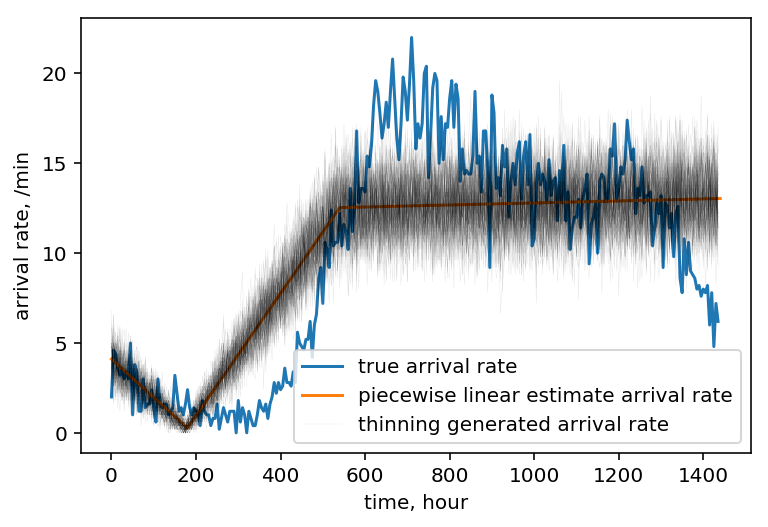

In [457]:
# Plot true arrival rate.
plt.plot(subinterval[:-1],counts/count_tw_min)


# # Plot estimate arrival rate
plt.plot(interval,lam_hour/60)

# Plot generated arrival rate
for i in range(n_exper):
    T_i_list = T_list_mat_pl_thinning[i,:]
    T_i_list = T_i_list[T_i_list > -1]
    T_i_list_hour = T_i_list*60
    generated_hist_bins = np.arange(0,24*60+1,count_tw_min)
    generated_hist_num = np.histogram(T_i_list_hour,bins=generated_hist_bins)[0]/count_tw_min
    plt.plot(subinterval[:-1],generated_hist_num,c='k',alpha=0.1,lw=0.2)

plt.xlabel('time, hour')
plt.ylabel('arrival rate, /min')
plt.legend(['true arrival rate','piecewise linear estimate arrival rate','thinning generated arrival rate'])